# Calculating and plotting running mean APWP

## Import scientific Python libraries

PmagPy can be pip installed ```pip install pmagpy``` and the rest are available through conda

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
from bayesian_pep import *
#import seaborn as sns
%config InlineBackend.figure_format='retina'

from scripts.auxiliar import get_files_in_directory, spherical2cartesian

## Import the data

In [2]:
current_path = os.getcwd() 
data_path_PP = current_path + "/data/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"
df_NAM = pd.read_excel(data_path_PP + file_name, engine='openpyxl')
df_NAM.columns

Index(['name', 'min_age', 'max_age', 'age', 'slat', 'slon', 'N', 'k',
       'alpha95', 'dp', 'dm', 'plat', 'plon', 'K', 'A95', 'plateID',
       'lithology', 'Rlat', 'Rlon', 'Euler_lat', 'Euler_lon', 'Euler_ang',
       'author', 'Q', 'reliability', 'age constraints'],
      dtype='object')

In [3]:
df_NAM.head()

,name,min_age,max_age,age,slat,slon,N,k,alpha95,dp,...,lithology,Rlat,Rlon,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints
0,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,NaN,...,volcanic,-86.3,5.7,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron
1,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,8.5,...,volcanic,-86.4,9.2,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study)
2,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,6.9,...,volcanic,-85.3,-94.1,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...
3,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,3.5,...,volcanic,-88.9,-75.1,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated)
4,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,7.9,...,clastics,-80.0,4.2,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy


## Plot the poles

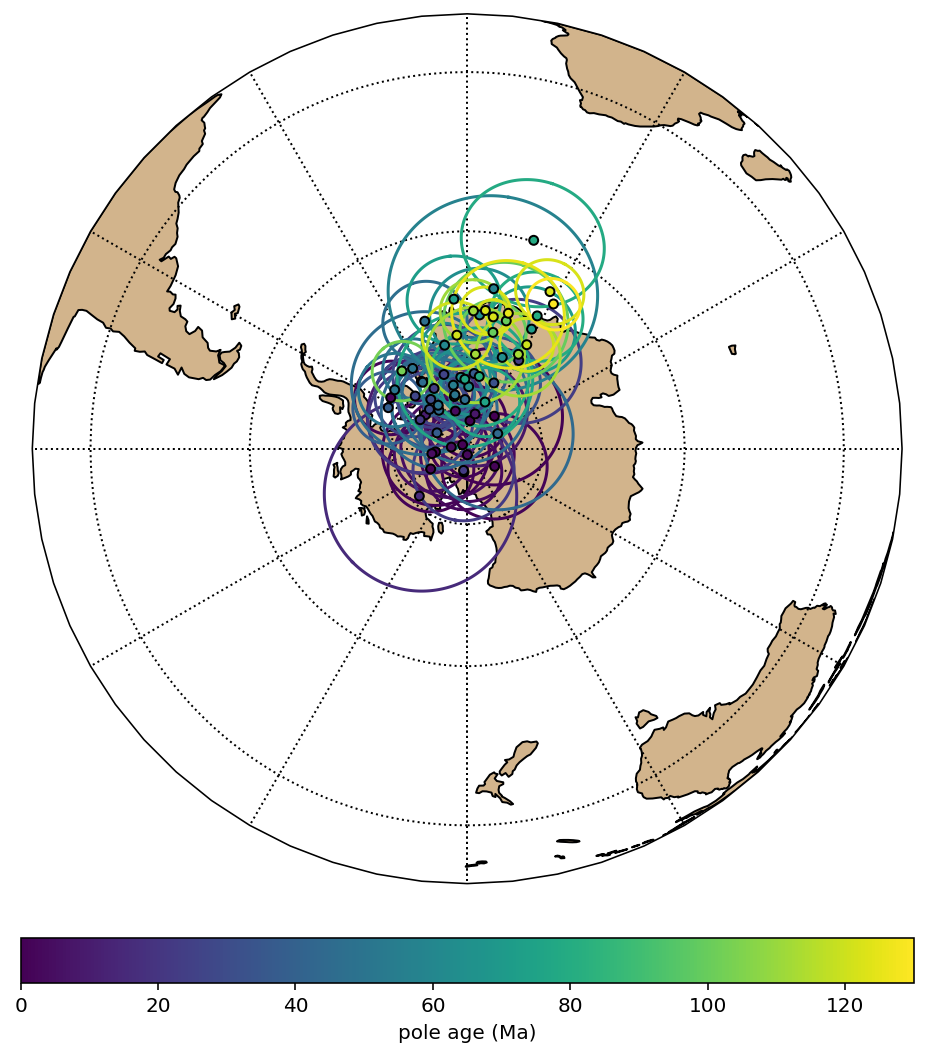

In [4]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, df_NAM.plon, df_NAM.plat, df_NAM.alpha95, df_NAM.age, 0, 130)
plt.show()

## Calculate the running mean

Below a function is defined for calculating a running mean based on a specified window length and spacing. The names for the dataframe columns are currently hardcoded in (could be good to generalize the function in this regard, but this will work for the moment).

In [5]:
def running_mean_APWP(data,window_length,spacing,max_age,min_age,fig_name=None):
    mean_pole_ages = np.arange(min_age,max_age+spacing,spacing)
    running_means = pd.DataFrame(columns=['age','N','alpha95','plon','plat'])
    for age in mean_pole_ages:
        window_min = age - (window_length/2)
        window_max = age + (window_length/2)
        poles = data.loc[(data['age'] >= window_min) & (data['age'] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles['plon'].tolist(),inc=poles['plat'].tolist())
        running_means.loc[age] = [age,mean['n'],mean['alpha95'],mean['dec'],mean['inc']]
    return running_means

In [6]:
NA_RM_20_10 = running_mean_APWP(df_NAM,20,10,110,0)
NA_RM_30_10 = running_mean_APWP(df_NAM,30,10,110,0)

In [7]:
NA_RM_20_10 = NA_RM_20_10.reset_index(drop=1)
NA_RM_20_10

,age,N,alpha95,plon,plat
0,0.0,14.0,2.451638,307.713863,-87.713097
1,10.0,15.0,2.518633,292.832373,-87.709272
2,20.0,11.0,3.710295,325.319043,-83.977929
3,30.0,13.0,3.056739,336.543106,-83.081653
4,40.0,14.0,2.764720,334.726672,-81.876509
5,50.0,12.0,3.627429,340.724562,-80.305351
6,60.0,11.0,3.659331,351.635982,-78.696684
7,70.0,12.0,4.153305,10.567316,-75.648617
8,80.0,7.0,6.838549,15.077436,-74.052240
9,90.0,4.0,5.702669,18.118438,-74.186230


## Plot the running mean APWPs

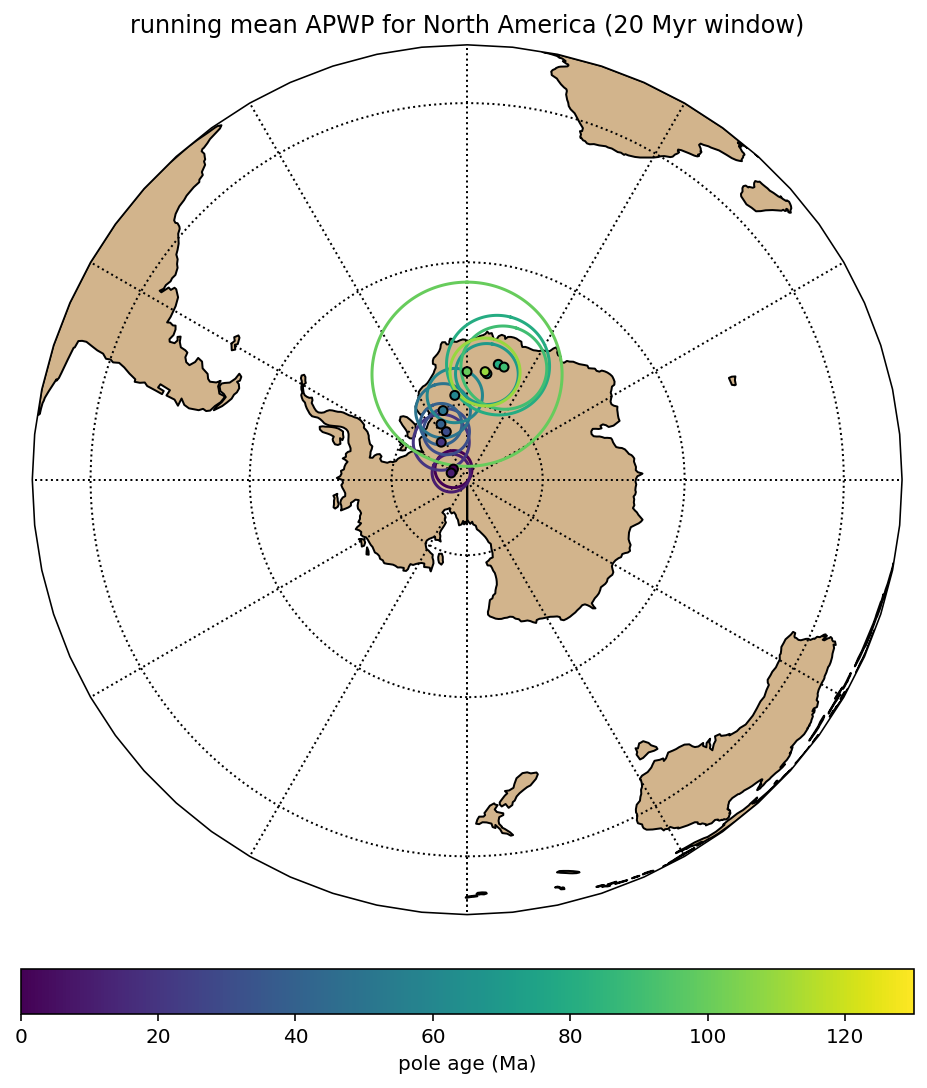

In [8]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, NA_RM_20_10.plon.tolist(), NA_RM_20_10.plat.tolist(), 
                 NA_RM_20_10.alpha95.tolist(), NA_RM_20_10.age.tolist(),0,130)
plt.title('running mean APWP for North America (20 Myr window)')
plt.show()

In [9]:
with pm.Model() as model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -1., testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    start_age = pm.Normal('start_pole_age',mu= NA_RM_20_10['age'].max(), sigma=10.)
    print('starting pole age is: ', str(NA_RM_20_10['age'].max()))
    
    start_index = start_pole_age = NA_RM_20_10['age'].argmax()
    
    start_lon_lat = [NA_RM_20_10['plon'].tolist()[start_index], NA_RM_20_10['plat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(NA_RM_20_10['alpha95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    for i in range(NA_RM_20_10.shape[0]):
        age = pm.Normal('t'+str(i), mu=NA_RM_20_10['age'][i], sigma=10.)
        print('pole '+str(i)+' age: ',NA_RM_20_10['age'][i])
#         print(start, euler_1, rate_1, start_age, age)
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(NA_RM_20_10['alpha95'].tolist()[i]), 
                            observed=[NA_RM_20_10['plon'].tolist()[i], NA_RM_20_10['plat'].tolist()[i]])
        
    trace_1e = pm.sample(10000, step = pm.Metropolis(), compute_convergence_checks=1, cores=1, init='auto')
    
#     start={'euler_1': np.array([1., 1.]), 'rate_1_interval__': np.array(0.), 
#                         'start_pole_age': np.array(110.), 'start_pole': np.array([0.,0.]), 
#                         't0': np.array(0.), 't1': np.array(10.), 't2': np.array(20.), 't3': np.array(30.), 't4': np.array(40.), 
#                         't5': np.array(50.), 't6': np.array(60.), 't7': np.array(70.), 't8': np.array(80.), 't9': np.array(90.), 
#                         't10': np.array(100.), 't11': np.array(110.)}

starting pole age is:  110.0
starting pole lon/lat: [9.42655055177144, -75.40984783942655] starting pole k:  912.2343682155031
pole 0 age:  0.0
pole 1 age:  10.0
pole 2 age:  20.0
pole 3 age:  30.0
pole 4 age:  40.0
pole 5 age:  50.0
pole 6 age:  60.0
pole 7 age:  70.0
pole 8 age:  80.0
pole 9 age:  90.0
pole 10 age:  100.0
pole 11 age:  110.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [t11]
>Metropolis: [t10]
>Metropolis: [t9]
>Metropolis: [t8]
>Metropolis: [t7]
>Metropolis: [t6]
>Metropolis: [t5]
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 1812 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_1e, compact=1)
plt.subplots_adjust(hspace = 1 )
plt.savefig('1_euler_inversion_traceplot.pdf', bbox_inches='tight')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


In [11]:
# pm.save_trace(trace_1e, 'code_output/1_euler_trace', overwrite=1)

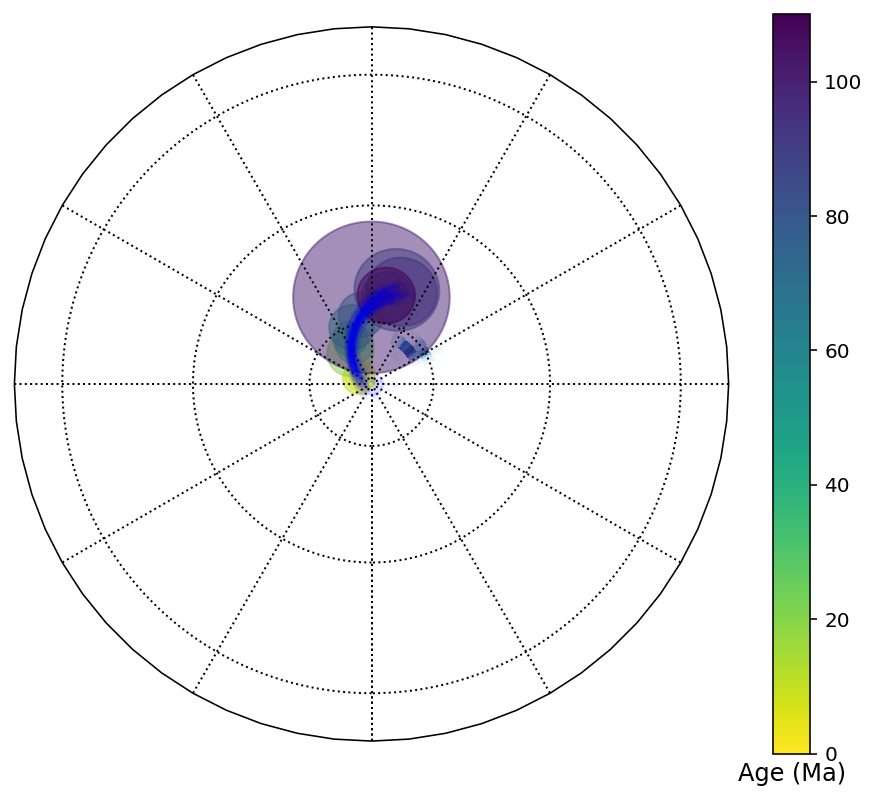

In [16]:
plot_trace_1e(trace_1e, NA_RM_20_10[['plon', 'plat']].to_numpy(), NA_RM_20_10['alpha95'], NA_RM_20_10['age'].tolist(), 0, -90, 100, 100, savefig = 1, figname= '1_Euler_inversion_.pdf',cmap='Blues')

In [ ]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, NA_RM_30_10.plon.tolist(), NA_RM_30_10.plat.tolist(), 
                 NA_RM_30_10.alpha95.tolist(), NA_RM_30_10.age.tolist(),0,130)
plt.title('running mean APWP for North America (30 Myr window)')
plt.show()